In [2]:
import os
import pathlib
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ssl

In [120]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [121]:
ROOT_PATH = '/home/creep/Documents/Work/DSP_Labs'
train_data_directory = os.path.join(ROOT_PATH, 'train_data')
test_data_directory = os.path.join(ROOT_PATH, 'test_data')

In [122]:
data_root = pathlib.Path(train_data_directory)

In [123]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

In [124]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['real', 'spoof']

In [125]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'real': 0, 'spoof': 1}

In [126]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


In [127]:
img_path = all_image_paths[0]
img_path

'/home/creep/Documents/Work/DSP_Labs/train_data/spoof/YOUTUBE_TSLCD1510_LGK350EK8_S1_id34_s0_95.png'

In [128]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x88\x00\...


In [129]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(392, 392, 3)
<dtype: 'uint8'>


In [130]:
img_final = tf.image.resize(img_tensor, [224, 224])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 3)
0.0
1.0


In [131]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0
  return image

In [132]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

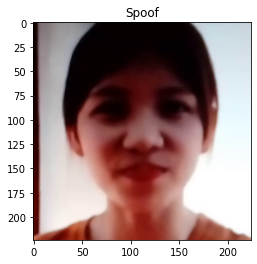

In [134]:
image_path = all_image_paths[0]
label = all_image_labels[0]
plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

In [135]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [136]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [137]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

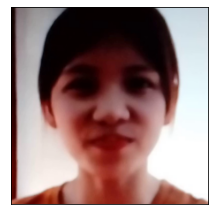

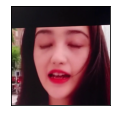

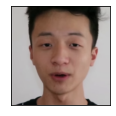

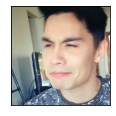

In [138]:
plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [139]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
label_ds

<TensorSliceDataset shapes: (), types: tf.int64>

In [140]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

spoof
spoof
real
spoof
spoof
spoof
spoof
spoof
spoof
spoof


In [141]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

In [142]:
image_count = len(all_image_paths)
image_count

8299

In [143]:
BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [144]:
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [146]:
resnet = tf.keras.applications.resnet_v2.ResNet152V2(input_shape=(224, 224, 3), include_top=False)
resnet.trainable=False

In [147]:
def change_range(image, label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [148]:
train_size = int(0.7 * image_count)
test_size = int(0.3 * image_count)

train_dataset = keras_ds.take(train_size)
test_dataset = keras_ds.skip(train_size)
# test_dataset = test_dataset.take(test_size)

In [149]:
# image_batch, label_batch = next(iter(keras_ds))
image_batch, label_batch = next(iter(train_dataset))

In [150]:
feature_map_batch = resnet(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 2048)


In [160]:
model = tf.keras.Sequential([
  resnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names)-1, activation = 'sigmoid')])

In [161]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)


min logit: 0.08529356
max logit: 0.8210552

Shape: (32, 1)


In [162]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])

In [163]:
len(model.trainable_variables)

2

In [164]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049      
Total params: 58,333,697
Trainable params: 2,049
Non-trainable params: 58,331,648
_________________________________________________________________


In [165]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

260.0

In [166]:
model.fit(ds, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
260/260 [==============================] - 762s 3s/step - loss: 0.3244 - auc_3: 0.8191
Epoch 2/5
260/260 [==============================] - 1029s 4s/step - loss: 0.2136 - auc_3: 0.9444
Epoch 3/5
260/260 [==============================] - 1271s 5s/step - loss: 0.1806 - auc_3: 0.9618
Epoch 4/5
260/260 [==============================] - 879s 3s/step - loss: 0.1572 - auc_3: 0.9714
Epoch 5/5
260/260 [==============================] - 763s 3s/step - loss: 0.1422 - auc_3: 0.9761


In [167]:
model.metrics_names

['loss', 'auc_3']

In [168]:
test_loss, test_auc = model.evaluate(test_dataset, steps=steps_per_epoch)
test_auc

260/260 [==============================] - 754s 3s/step - loss: 0.1978 - auc_3: 0.9695


0.9694803357124329

********************

In [169]:
data_test_root = pathlib.Path(test_data_directory)
data_test_root

PosixPath('/home/creep/Documents/Work/DSP_Labs/test_data')

In [170]:
all_test_image_paths = list(data_test_root.glob('**/*.png'))

In [171]:
all_test_image_paths = list(data_test_root.glob('**/*.png'))
all_test_image_paths = [str(path) for path in all_test_image_paths]
random.shuffle(all_test_image_paths)

In [172]:
len(all_test_image_paths)

10000

In [173]:
test_img_path = all_test_image_paths[0]
test_img_path

'/home/creep/Documents/Work/DSP_Labs/test_data/3ZY3WI84.png'

In [174]:
test_img_raw = tf.io.read_file(test_img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x88\x00\...


In [175]:
test_img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(392, 392, 3)
<dtype: 'uint8'>


In [176]:
test_img_final = tf.image.resize(test_img_tensor, [224, 224])
test_img_final = test_img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(224, 224, 3)
0.0
1.0


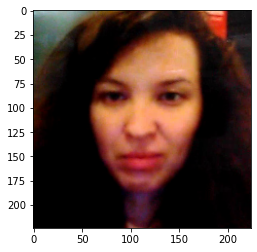

In [177]:
test_image_path = all_test_image_paths[0]
plt.imshow(load_and_preprocess_image(test_image_path))
plt.grid(False)
print()

In [178]:
test_path_ds = tf.data.Dataset.from_tensor_slices(all_test_image_paths)
test_path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [179]:
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_image_ds

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

In [180]:
test_image_count = len(all_test_image_paths)
test_image_count

10000

In [181]:
TEST_BATCH_SIZE = 10

ds_test = test_image_ds.shuffle(buffer_size=test_image_count)
ds_test = ds_test.repeat()
ds_test = ds_test.batch(TEST_BATCH_SIZE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)
ds_test

<PrefetchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [182]:
predictions = model.predict(ds_test, steps=1000)

In [183]:
len(predictions)

10000

In [ ]:
# np.savetxt("prediction.csv", predictions, delimiter=',')

In [185]:
all_test_image_paths

['/home/creep/Documents/Work/DSP_Labs/test_data/3ZY3WI84.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/5WFWCK5M.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/93CFOW5F.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/M621D5LZ.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/EVF1Z74G.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/F38JYQYH.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/JSIEGHV1.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/2XWQ69PN.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/AQJV1ZLL.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/0UROIVAU.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/U5WHHPVI.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/4DOJ69VY.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/KXSV68VI.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/ET1ND28I.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/6OAB8CLH.png',
 '/home/creep/Documents/Work/DSP_Labs/test_data/K8PEF4G

In [186]:
pd.DataFrame(all_test_image_paths).to_csv("~/Documents/Work/DSP_Labs/file.csv")

In [ ]:
# pd.DataFrame(predictions).to_csv("~/Documents/Work/DSP_Labs/file2.csv")

In [187]:
df = pd.DataFrame(predictions)
df

,0
0,0.999591
1,0.906076
2,0.930505
3,0.227207
4,0.042290
...,...
9995,0.101848
9996,0.993931
9997,0.727120
9998,0.935107


In [189]:
df['img'] = all_test_image_paths
df['real'] = df[0]
df = df.drop(columns=[0])
df['img'] = df['img'].str.slice(46)
df = df.rename(columns={'img': 0, 'real': 2})
df

,0,2
0,3ZY3WI84.png,0.999591
1,5WFWCK5M.png,0.906076
2,93CFOW5F.png,0.930505
3,M621D5LZ.png,0.227207
4,EVF1Z74G.png,0.042290
...,...,...
9995,RR7HNFEF.png,0.101848
9996,S1929MWJ.png,0.993931
9997,47UG7ADQ.png,0.727120
9998,1KCINENG.png,0.935107


In [4]:
df1 = pd.read_csv('~/Documents/Work/DSP_Labs/predictions_v2.csv')
df1

,0,2
0,3ZY3WI84.png,0.999591
1,5WFWCK5M.png,0.906076
2,93CFOW5F.png,0.930505
3,M621D5LZ.png,0.227207
4,EVF1Z74G.png,0.042290
...,...,...
9995,RR7HNFEF.png,0.101848
9996,S1929MWJ.png,0.993931
9997,47UG7ADQ.png,0.727120
9998,1KCINENG.png,0.935107


In [7]:
df1['2'] = 1 - df1['2']
df1

,0,2
0,3ZY3WI84.png,0.000409
1,5WFWCK5M.png,0.093924
2,93CFOW5F.png,0.069495
3,M621D5LZ.png,0.772793
4,EVF1Z74G.png,0.957710
...,...,...
9995,RR7HNFEF.png,0.898152
9996,S1929MWJ.png,0.006069
9997,47UG7ADQ.png,0.272880
9998,1KCINENG.png,0.064893


In [9]:
df1.loc[:, ['0', '2']].to_csv('~/Documents/Work/DSP_Labs/preds.csv', index=False)